In [1]:
import pandas as pd
import numpy as np
from time import process_time
from joblib import dump
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.ldamodel import LdaModel
from data_preprocessing import *
from model import *

import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Layer
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Embedding, Input, Dense, LSTM, Dropout, Flatten, Bidirectional, Conv1D, concatenate, SpatialDropout1D
from tensorflow.keras.layers import MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalAveragePooling2D, GlobalAveragePooling1D 

print(tf.__version__)

2.2.0


In [2]:
training_path = "../dataset/original-dataset/marathi-training-data.csv"
training_data = read_data(training_path)
training_data

,text,label
0,"प्रा . प्रताप हरिदास : होय , मला वाटते की हा ए...",com_tech
1,"तर , विशिष्ट गोष्टींद्वारे , ठराविक कायद्यांद्...",bioche
2,- - - - - - - - - - - - - - - - - - - - - - - ...,cse
3,"तर , आपला अर्धा चिन्ह 9 वाजता असेल .",phy
4,"म्हणून , मी असे म्हणालो की जर शेकडो , हजारो कि...",phy
...,...,...
41992,"जरी आपण डेटा कूटबद्ध केला , तरीही हा मुख्य व्य...",cse
41993,"ते म्हणतात - "" ज्याला पाहण्यासाठी डोळे , ऎकण्य...",com_tech
41994,"प्रथम क्रोनोलॉजिकल , क्रॉनोलॉजी म्हणजे आपल्याल...",com_tech
41995,"त्या थोड्या तपशीलावर येईल , जेणेकरून संपूर्ण ग...",bioche


In [3]:
training_data.label.value_counts()

com_tech    17995
phy          9656
cse          9344
bioche       5002
Name: label, dtype: int64

In [4]:
val_path = "../dataset/original-dataset/marathi-validation-data.csv"
val_data = read_data(val_path)
val_data

,text,label
0,1 ची ओळ .,cse
1,"तर , ही एक टॉवर आहे जी टॉवरवर निश्चित केली जात...",phy
2,"तर , थ्रेडच्या परतीच्या स्थितीस पास करण्यासाठी...",cse
3,आपण लोक शोधत आहात जे आपल्यासाठी काहीतरी करू शक...,com_tech
4,लिनक्स कर्नल अनुसूचीतकरणामध्ये अशी तंत्र असण्य...,cse
...,...,...
3775,"नंतर वृद्धत्व , व्हॉट मोठ्या प्रमाणात फ्रॉन 12...",bioche
3776,आणि मग सुद्धा आपल्याला काही सेकंदांनंतर माहित ...,phy
3777,"तर , आपण ELF शीर्षलेखासह प्रारंभ करू .",cse
3778,"तर , त्या क्रॉस्टची जाडी आहे .",phy


In [5]:
x_train = training_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_train = training_data.label.values.tolist()
x_val = val_data.text.apply(lambda x: clean_text(x)).values.tolist()
y_val = val_data.label.values.tolist()
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

41997
41997
3780
3780


In [6]:
y_train, y_val = label_encoder(y_train, y_val)

In [7]:
y_train = y_train.reshape(y_train.shape[0], -1)
y_val = y_val.reshape(y_val.shape[0], -1)
print(y_train.shape)
print(y_val.shape)

(41997, 1)
(3780, 1)


In [8]:
pad_len=100
padding_type='post'
truncating_type='post'

In [9]:
tokenizer, x_train_tokenzied, x_val_tokenzied = tokenize_text(x_train, x_val)

In [10]:
x_train_padded, x_val_padded = pad_text(x_train_tokenzied, 
                                        x_val_tokenzied, 
                                        pad_len, 
                                        padding_type, 
                                        truncating_type)

In [ ]:
dump(tokenizer, "../tokenizers/DL-raw-tokenizer-100.pk1")

In [11]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(41997, 100)
(3780, 100)


In [12]:
vocab = tokenizer.word_index
len(vocab.keys())

52575

# Domain Specific Fasttext Embeddings

In [13]:
length = [len(text.split()) for text in x_train]
df = pd.DataFrame(list(zip(x_train, training_data.label.values.tolist(), length)), columns=['train', 'label', 'length'])
df

,train,label,length
0,प्रा प्रताप हरिदास होय मला वाटते की हा एक महत्...,com_tech,43
1,तर विशिष्ट गोष्टींद्वारे ठराविक कायद्यांद्वारे...,bioche,40
2,म्हणून डेटा कुठे स्थित आहे जेथे विस्तार इत्याद...,cse,24
3,तर आपला अर्धा चिन्ह 9 वाजता असेल,phy,7
4,म्हणून मी असे म्हणालो की जर शेकडो हजारो किंवा ...,phy,26
...,...,...,...
41992,जरी आपण डेटा कूटबद्ध केला तरीही हा मुख्य व्यवस...,cse,28
41993,ते म्हणतात ज्याला पाहण्यासाठी डोळे ऎकण्यासाठी ...,com_tech,19
41994,प्रथम क्रोनोलॉजिकल क्रॉनोलॉजी म्हणजे आपल्याला ...,com_tech,11
41995,त्या थोड्या तपशीलावर येईल जेणेकरून संपूर्ण गोष...,bioche,11


In [14]:
df[df.length > 200].label.value_counts()

phy    16
Name: label, dtype: int64

In [13]:
start = process_time()
embedding_path1 = "/home/eastwind/word-embeddings/fasttext/TechDofication.mr.raw.ft.skipgram.d300.vec"
embedding_matrix1 = get_embedding_matrix(embedding_path1, vocab, embedding_dim=300)
end = process_time()
print("Total time taken: ", end-start)
embedding_matrix1.shape

51245
Total time taken:  5.379749596


(52576, 300)

In [14]:
input_dim1 = embedding_matrix1.shape[0]
embedding_dim1 = 300
input_len = pad_len
print("Input dimension 1: ", input_dim1)
print("Embedding dimensions 1: ", embedding_dim1)
print("Input sentence dimensions 1: ", input_len)

Input dimension 1:  52576
Embedding dimensions 1:  300
Input sentence dimensions 1:  100


# Multi-channel BiLSTM-CNN Architecture with Attention

In [23]:
class AttentionLayer(Layer):
    
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        
        
    def build(self, attention_input):
        lstm_shape, cnn_shape = attention_input
        self.W_in = self.add_weight(shape=(lstm_shape[-1], 1),
                                    initializer='glorot_normal',
                                    trainable=True,
                                    name='input_attention_weights')
        '''
        self.W_context = self.add_weight(shape=(cnn_shape[-1], 1),
                                         initializer='glorot_normal',
                                         name='context_attention_weights')
        '''
        self.b = self.add_weight(shape=(lstm_shape[1], 1),
                                         initializer='glorot_normal',
                                         name='attention_bias')
        super(AttentionLayer, self).build(attention_input)
        
        
    def call(self, attention_input):
        lstm_output, cnn_output = attention_input
        '''
        et = K.squeeze(K.tanh(K.dot(lstm_output, self.W_in) +
                              K.dot(cnn_output, self.W_context) +
                              self.b), axis=-1)
        '''
        et = K.dot(cnn_output.T, lstm_output)
        et = et/linalg.norm(cnn_output)*linalg.norm(lstm_output)
        at = K.expand_dims(K.softmax(et), axis=-1)
        attention_output = K.sum(at * cnn_output, axis=1)
        return attention_output
    
    
    def compute_output_shape(self, attention_input):
        return (attention_input[0], attention_input[-1])
    
    
    def get_config(self):
        return super(AttentionLayer, self).get_config()

In [24]:
Input1 = Input(shape=(input_len,))
Embedding_layer1 = Embedding(input_dim=input_dim1, 
                             output_dim=embedding_dim1, 
                             weights=[embedding_matrix1], 
                             trainable=False)(Input1)

# Input 1(BiLSTM):
Lstm = Bidirectional(LSTM(128, return_sequences=True))(Embedding_layer1)
Dropout_lstm = Dropout(0.3)(Lstm)

# Input 2 (CNN):
Conv = Conv1D(filters=256, kernel_size=5, padding='same')(Embedding_layer1)
Dropout_conv = Dropout(0.3)(Conv)

merged = AttentionLayer()([Dropout_lstm, Dropout_conv])
Dense1 = Dense(64, activation='relu')(merged)
Dropout_dense = Dropout(0.25)(Dense1)
outputs = Dense(4, activation='softmax')(Dropout_dense)

classifier = Model(inputs=Input1, outputs=outputs)
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
classifier.summary()

AttributeError: in user code:

    <ipython-input-23-493242c2c633>:31 call  *
        et = K.dot(cnn_output.T, lstm_output)

    AttributeError: 'Tensor' object has no attribute 'T'


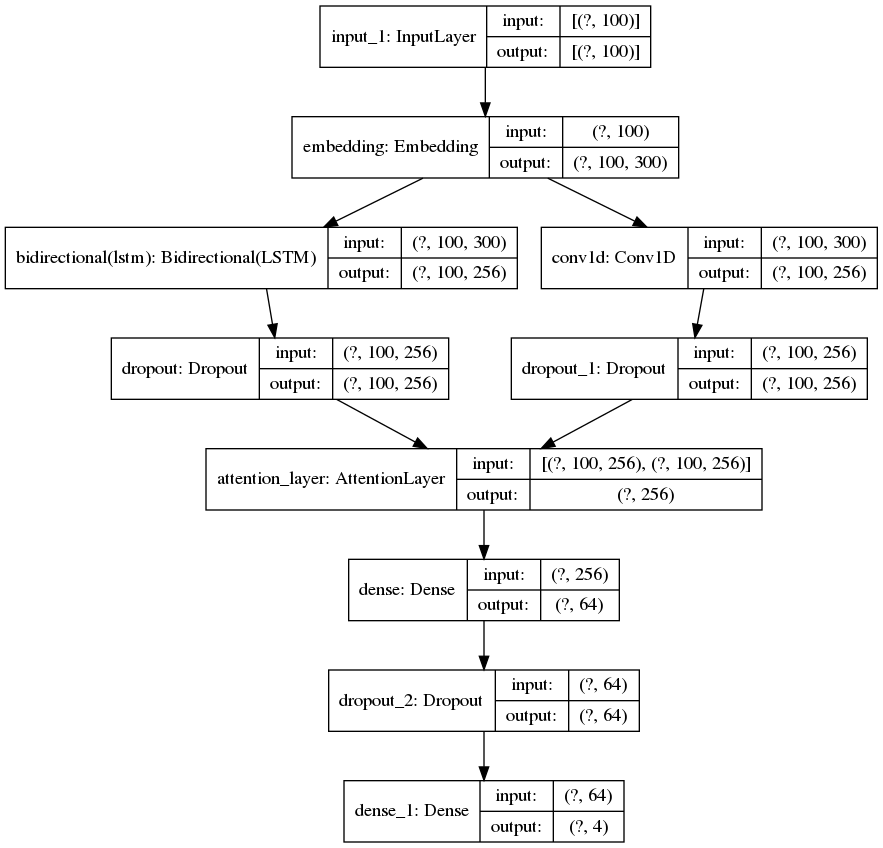

In [18]:
plot_model(classifier, show_shapes=True)

In [22]:
history2 = classifier.fit(x_train_padded, 
                          y_train, 
                          epochs=8,
                          batch_size=128,
                          verbose=1,
                          validation_data=(x_val_padded, y_val))

Epoch 1/8
329/329 [==============================] - 128s 390ms/step - loss: 0.7006 - acc: 0.7944 - val_loss: 0.4666 - val_acc: 0.8534
Epoch 2/8
329/329 [==============================] - 142s 431ms/step - loss: 0.4277 - acc: 0.8608 - val_loss: 0.4362 - val_acc: 0.8566
Epoch 3/8
329/329 [==============================] - 136s 414ms/step - loss: 0.3830 - acc: 0.8725 - val_loss: 0.3957 - val_acc: 0.8672
Epoch 4/8
329/329 [==============================] - 140s 427ms/step - loss: 0.3565 - acc: 0.8808 - val_loss: 0.4293 - val_acc: 0.8608
Epoch 5/8
329/329 [==============================] - 144s 437ms/step - loss: 0.3354 - acc: 0.8882 - val_loss: 0.3757 - val_acc: 0.8725
Epoch 6/8
329/329 [==============================] - 158s 479ms/step - loss: 0.3093 - acc: 0.8967 - val_loss: 0.4075 - val_acc: 0.8635
Epoch 7/8
329/329 [==============================] - 162s 494ms/step - loss: 0.2885 - acc: 0.9043 - val_loss: 0.3664 - val_acc: 0.8757
Epoch 8/8
329/329 [==============================] - 15

In [19]:
history2 = classifier.fit(x_train_padded, 
                          y_train, 
                          epochs=8,
                          batch_size=128,
                          verbose=1,
                          validation_data=(x_val_padded, y_val))

Epoch 1/8
329/329 [==============================] - 324s 984ms/step - loss: 0.5097 - acc: 0.8141 - val_loss: 0.3962 - val_acc: 0.8569
Epoch 2/8
329/329 [==============================] - 234s 710ms/step - loss: 0.3694 - acc: 0.8684 - val_loss: 0.3570 - val_acc: 0.8693
Epoch 3/8
329/329 [==============================] - 247s 751ms/step - loss: 0.3322 - acc: 0.8798 - val_loss: 0.3490 - val_acc: 0.8767
Epoch 4/8
329/329 [==============================] - 272s 827ms/step - loss: 0.3014 - acc: 0.8915 - val_loss: 0.3398 - val_acc: 0.8778
Epoch 5/8
329/329 [==============================] - 270s 822ms/step - loss: 0.2691 - acc: 0.9042 - val_loss: 0.3208 - val_acc: 0.8833
Epoch 6/8
329/329 [==============================] - 269s 819ms/step - loss: 0.2408 - acc: 0.9144 - val_loss: 0.3559 - val_acc: 0.8820
Epoch 7/8
329/329 [==============================] - 277s 842ms/step - loss: 0.2119 - acc: 0.9249 - val_loss: 0.3848 - val_acc: 0.8701
Epoch 8/8
329/329 [==============================] - 28

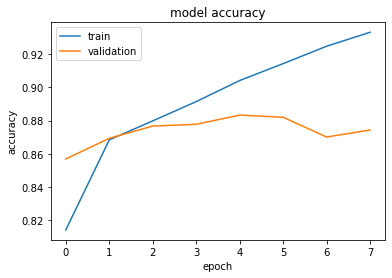

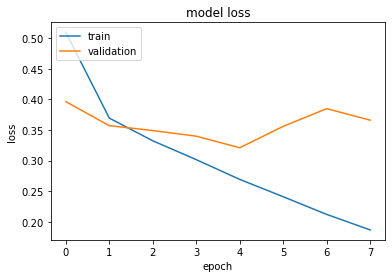

In [20]:
plot_curves(history2)

In [21]:
results2 = np.argmax(classifier.predict(x_val_padded), axis=-1)
acc, precision, recall, f1 = classification_report(y_val, results2)
print("Validation Accuracy: ", acc)
print("\nPrecision: ", precision)
print("Average Precision: ", np.mean(precision))
print("\nRecall: ", recall)
print("Average Recall: ", np.mean(recall))
print("\nF1-Score: ", f1)
print("Average F1-Score: ", np.mean(f1))

Validation Accuracy:  0.8743386243386243

Precision:  [0.84848485 0.85933661 0.86723769 0.92457421]
Average Precision:  0.8749083386083418

Recall:  [0.8        0.92956811 0.91525424 0.78350515]
Average Recall:  0.8570818745599007

F1-Score:  [0.82352941 0.89307373 0.89059923 0.84821429]
Average F1-Score:  0.8638541647683352


In [27]:
save_model(classifier, "BiLSTM-CNN-Attention/BiLSTM-CNN-Attention-f1-8658")

Confusion matrix, without normalization


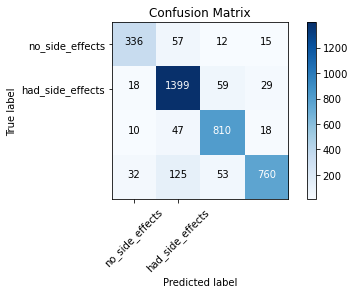

In [26]:
plot_confusion_matrix(y_val, 
                      results2, 
                      classes=['no_side_effects','had_side_effects'], 
                      title='Confusion Matrix',
                      normalize=False)